In [1]:
import numpy as np
from scipy.stats import multivariate_normal
import scipy
import matplotlib.pyplot as plt

In [2]:
from GHKF import GHKF
from EKF import EKF

Imported GHKF
Imported EKF


In [3]:
import sympy
from IPython.display import display
sympy.init_printing(use_latex='mathjax')

In [4]:
from time import perf_counter

In [5]:
def trueMeanAndCov(m, cov, f, u, f_return_dim, x_dim, dt, for_measurement=False, f_kwargs=None):
    n = 100
    samples = multivariate_normal.rvs(m.flatten(), cov, n)
    transformed_samples = np.array([]).reshape(0, f_return_dim)
    if f_kwargs is None:
        f_kwargs = {}
    for s in samples:
        sample = s.reshape(x_dim, 1)
        if for_measurement: # measurement model does not take u
            transformed = f(sample, **f_kwargs).reshape(1, f_return_dim)
        else:
            transformed = f(sample, u, dt, **f_kwargs).reshape(1, f_return_dim)
        transformed_samples = np.vstack((transformed_samples, transformed))
    result_mean = np.mean(transformed_samples, axis=0)
    result_cov = np.cov(transformed_samples.T)
    return result_mean.reshape(f_return_dim, 1), result_cov.reshape(f_return_dim, f_return_dim)

#### Balistic tracking

In [5]:
h, v, b, T, a1, a2, g = sympy.symbols('h, v, b, T, a1, a2, g')
A = sympy.Matrix([-v*T + h, 
                  -a1 * sympy.exp(-a2*h) * g * v**2 * T / (2 * b) + T * g + v, 
                  b])
state = sympy.Matrix([h, v, b])
J = A.jacobian(state)
display(state)
display(A)
display(J)

⎡h⎤
⎢ ⎥
⎢v⎥
⎢ ⎥
⎣b⎦

⎡          -T⋅v + h          ⎤
⎢                            ⎥
⎢          2  -a₂⋅h          ⎥
⎢  T⋅a₁⋅g⋅v ⋅ℯ               ⎥
⎢- ──────────────── + T⋅g + v⎥
⎢        2⋅b                 ⎥
⎢                            ⎥
⎣             b              ⎦

⎡         1                    -T                   0        ⎤
⎢                                                            ⎥
⎢           2  -a₂⋅h              -a₂⋅h              2  -a₂⋅h⎥
⎢T⋅a₁⋅a₂⋅g⋅v ⋅ℯ         T⋅a₁⋅g⋅v⋅ℯ           T⋅a₁⋅g⋅v ⋅ℯ     ⎥
⎢───────────────────  - ─────────────── + 1  ────────────────⎥
⎢        2⋅b                   b                      2      ⎥
⎢                                                  2⋅b       ⎥
⎢                                                            ⎥
⎣         0                     0                   1        ⎦

In [6]:
M, a = sympy.symbols('M, a')
H = sympy.Matrix([sympy.sqrt(M**2 + (h - a) ** 2)])
state = sympy.Matrix([h, v, b])
J = H.jacobian(state)
display(state)
display(H)
display(J)

⎡h⎤
⎢ ⎥
⎢v⎥
⎢ ⎥
⎣b⎦

⎡   ________________⎤
⎢  ╱  2           2 ⎥
⎣╲╱  M  + (-a + h)  ⎦

⎡       -a + h            ⎤
⎢───────────────────  0  0⎥
⎢   ________________      ⎥
⎢  ╱  2           2       ⎥
⎣╲╱  M  + (-a + h)        ⎦

In [173]:
# q3 = 10000
# q4 = 10000
dt = 0.1
dt_filt = 0.5
dts_ratio = dt_filt // dt
# Q = np.array([[q3 * dt**3 / 3, q3 * dt**2 / 2, 0],
#               [q3 * dt**2 / 2, q3 * dt, 0],
#               [0, 0, q4 * dt]])
Q = 10_000 * np.eye(3)
Q_filt = 100_000 * np.eye(3)
R = 100_000 * np.eye(1)
R_filt = R
m = np.array([60960, 3048, 19161]).reshape(3, 1)
# P = np.diag([1, 1, 1])
P = np.diag([300_000, 1_000_000, 10_000])
nsteps = 300
p = 2
processModelkwargs = { 'a1': 1.754, 'a2': 1.49e-4, 'g': 9.81 }
Fkwargs = processModelkwargs
measurementModelkwargs = { 'M': 30480, 'a': 0 }
Hkwargs = measurementModelkwargs
def f(x, u, dt, **kwargs):
    h = x[0, 0]
    v = x[1, 0]
    b = x[2, 0]
#     a1 = kwargs['a1']
#     a2 = kwargs['a2']
#     g = kwargs['g']
#     x1_next = -dt * v + h
#     x2_next = -a1 * np.exp(-a2*h) * g * v**2 * dt / (2 * b) + dt * g + v
#     x3_next = b
    x1_next = -dt * v + h
    x2_next = v
    x3_next = b
    return np.array([x1_next, x2_next, x3_next]).reshape(3, 1)
def f_sim(x, u, dt, **kwargs):
    h = x[0, 0]
    v = x[1, 0]
    b = x[2, 0]
    a1 = kwargs['a1']
    a2 = kwargs['a2']
    g = kwargs['g']
    x1_next = -dt * v + h
    x2_next = -a1 * np.exp(-a2*h) * g * v**2 * dt / (2 * b) + dt * g + v
    x3_next = b
    return np.array([x1_next, x2_next, x3_next]).reshape(3, 1)
def h(x, **kwargs):
    M = kwargs['M']
    a = kwargs['a']
    h = x[0, 0]
    return np.array([np.sqrt(M**2 + (h - a)**2)]).reshape(1, 1)
# def h(x, **kwargs):
#     h = x[0, 0]
#     return np.array([h]).reshape(1, 1)

In [174]:
# def F(x, u, dt, **kwargs):
#     a1 = kwargs['a1']
#     a2 = kwargs['a2']
#     g = kwargs['g']
#     h = x[0, 0]
#     v = x[1, 0]
#     b = x[2, 0]
#     return np.array([[1, -dt, 0], 
#                      [dt * a1 * a2 * g * v**2 * np.exp(-h*a2) / (2*b), -dt*a1*g*v*np.exp(-a2*h)/b + 1, dt*a1*g*v**2*np.exp(-a2*h)/(2*b**2)],
#                      [0, 0, 1]])
def H(x, **kwargs):
    M = kwargs['M']
    a = kwargs['a']
    h = x[0, 0]
    return np.array([(-a + h)/np.sqrt(M**2 + (-a + h)**2), 0, 0]).reshape(1, 3)
# def H(x, **kwargs):
#     h = x[0, 0]
#     return np.array([1, 0, 0]).reshape(1, 3)

def F(x, u, dt, **kwargs):
    a1 = kwargs['a1']
    a2 = kwargs['a2']
    g = kwargs['g']
    h = x[0, 0]
    v = x[1, 0]
    b = x[2, 0]
    return np.array([[1, -dt, 0], 
                     [0, 1, 0],
                     [0, 0, 1]])

In [175]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, F=F, H=H, dt=dt_filt,
                              processModelkwargs=processModelkwargs, measurementModelkwargs=measurementModelkwargs, 
                               Fkwargs=Fkwargs, Hkwargs=Hkwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=p, dt=dt_filt,
                            processModelkwargs=processModelkwargs, measurementModelkwargs=measurementModelkwargs)

In [176]:
np.random.seed(2022)
x = m
# x = np.array([60960, 3048, 19161]).reshape(3, 1)
x_noisy = x + multivariate_normal.rvs([0, 0, 0], Q).reshape(3, 1)
xs = []
xs_noisy = []
xs_ekf = []
zs = []
xs_ekf = []
xs_ghkf = []
ts = []
ts_filt = []
xs_ghkf_predict = []
xs_ekf_predict= []
ks_filt = []
for k in range(nsteps): 
    u = 0
    x = f_sim(x, u, dt, **processModelkwargs)
#     x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f=f_sim, u=u, f_return_dim=3, x_dim=3, dt=dt,
#                           f_kwargs=processModelkwargs)
    xs.append(x)
    x_noisy = x + multivariate_normal.rvs([0, 0, 0], Q).reshape(3, 1)
    xs_noisy.append(x_noisy)
    if k % dts_ratio == 0:
        # measurement
        ekf.predict(u)
        ghkf.predict(u)
        xs_ghkf_predict.append(ghkf.m)
        xs_ekf_predict.append(ekf.m)
    #     z = h(x_noisy, **measurementModelkwargs)
        z, Pz = trueMeanAndCov(x_noisy, ghkf.P, f=h, u=u, f_return_dim=1, x_dim=3, 
                           dt=dt_filt, for_measurement=True, f_kwargs=measurementModelkwargs)
        z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
        ekf.update(z_noisy)
        ghkf.update(z_noisy)
        xs_ekf.append(ekf.m)
        xs_ghkf.append(ghkf.m)
        zs.append(z_noisy)
        ts_filt.append(k*dt)
        ks_filt.append(k)
    ts.append(k*dt)

In [177]:
true_x1 = list(map(lambda x: x[0, 0], xs))
true_x2 = list(map(lambda x: x[1, 0], xs))

In [178]:
index = 0 # 0 - height, 1 - velocity
h_ekf = list(map(lambda x: x[index, 0], xs_ekf))
h_ghkf = list(map(lambda x: x[index, 0], xs_ghkf))
h_ekf_predict = list(map(lambda x: x[index, 0], xs_ekf_predict))
h_ghkf_predict = list(map(lambda x: x[index, 0], xs_ghkf_predict))
v_ekf = list(map(lambda x: x[1, 0], xs_ekf))
v_ghkf = list(map(lambda x: x[1, 0], xs_ghkf))
measurements = list(map(lambda x: x[0, 0], zs))
measurements_on_h_axis = np.sqrt(np.power(measurements, 2) - measurementModelkwargs['M']**2) + measurementModelkwargs['a']

<ipython-input-178-07b11a231c13>:9: RuntimeWarning: invalid value encountered in sqrt
  measurements_on_h_axis = np.sqrt(np.power(measurements, 2) - measurementModelkwargs['M']**2) + measurementModelkwargs['a']


Difference between prediction and actual estimate

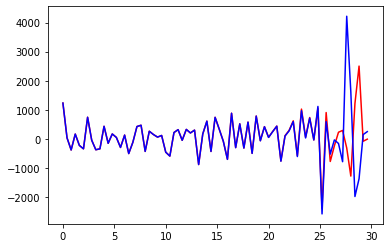

In [179]:
plt.plot(ts_filt, np.array(h_ekf) - np.array(h_ekf_predict), 'r-')
plt.plot(ts_filt, np.array(h_ghkf) - np.array(h_ghkf_predict), 'b-')
plt.show()

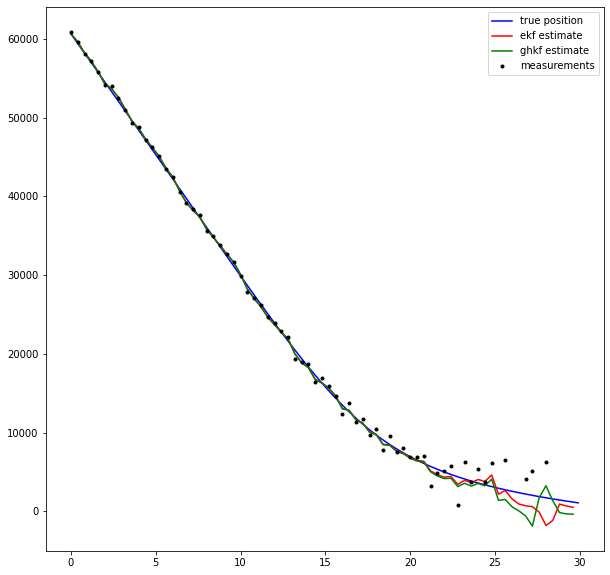

In [180]:
plt.figure(figsize=(10, 10))
plt.plot(ts, true_x1, 'b-')
plt.plot(ts_filt, h_ekf, 'r-')
plt.plot(ts_filt, h_ghkf, 'g-')
plt.plot(ts_filt, measurements_on_h_axis, 'k.')
plt.legend(['true position', 'ekf estimate', 'ghkf estimate', 'measurements'])
plt.show()

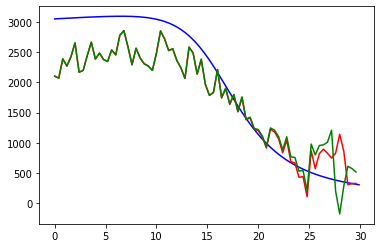

In [181]:
plt.plot(ts, true_x2, 'b-')
plt.plot(ts_filt, v_ekf, 'r-')
plt.plot(ts_filt, v_ghkf, 'g-')
plt.show()

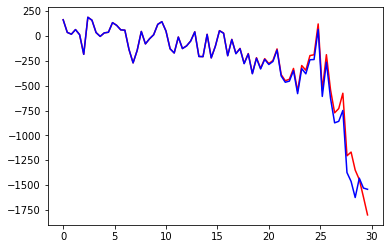

In [164]:
ekf_error = np.array(h_ekf) - np.array(true_x1)[ks_filt]
ghkf_error = np.array(h_ghkf) - np.array(true_x1)[ks_filt]
plt.plot(ts_filt, ekf_error, 'r-')
plt.plot(ts_filt, ghkf_error, 'b-')
plt.show()

#### 2-D object movement tracking

In [119]:
x1, vx, ax, y, vy, ay, T = sympy.symbols('x_1, v_x, a_x, y, v_y, a_y, T')
A = sympy.Matrix([x1 + T * vx + 0.5 * T**2 * ax, 
                  vx + T * ax, 
                  ax,
                  y + T * vy + 0.5 * T**2 * ay,
                  vy + T * ay,
                  ay])
state = sympy.Matrix([x1, vx, ax, y, vy, ay])
J = A.jacobian(state)
display(state)
display(A)
display(J)

⎡x₁ ⎤
⎢   ⎥
⎢vₓ ⎥
⎢   ⎥
⎢aₓ ⎥
⎢   ⎥
⎢ y ⎥
⎢   ⎥
⎢v_y⎥
⎢   ⎥
⎣a_y⎦

⎡     2                ⎤
⎢0.5⋅T ⋅aₓ + T⋅vₓ + x₁ ⎥
⎢                      ⎥
⎢      T⋅aₓ + vₓ       ⎥
⎢                      ⎥
⎢          aₓ          ⎥
⎢                      ⎥
⎢     2                ⎥
⎢0.5⋅T ⋅a_y + T⋅v_y + y⎥
⎢                      ⎥
⎢     T⋅a_y + v_y      ⎥
⎢                      ⎥
⎣         a_y          ⎦

⎡           2              ⎤
⎢1  T  0.5⋅T   0  0    0   ⎥
⎢                          ⎥
⎢0  1    T     0  0    0   ⎥
⎢                          ⎥
⎢0  0    1     0  0    0   ⎥
⎢                          ⎥
⎢                         2⎥
⎢0  0    0     1  T  0.5⋅T ⎥
⎢                          ⎥
⎢0  0    0     0  1    T   ⎥
⎢                          ⎥
⎣0  0    0     0  0    1   ⎦

In [120]:
x1, vx, ax, y, vy, ay = sympy.symbols('x_1, v_x, a_x, y, v_y, a_y')
H = sympy.Matrix([sympy.sqrt(x1**2 + y**2), sympy.atan(x1/y), (x1*vx + y*vy)/sympy.sqrt(x1**2 + y**2)])
state = sympy.Matrix([x1, vx, ax, y, vy, ay])
J = H.jacobian(state)
display(state)
display(H)
display(J)

⎡x₁ ⎤
⎢   ⎥
⎢vₓ ⎥
⎢   ⎥
⎢aₓ ⎥
⎢   ⎥
⎢ y ⎥
⎢   ⎥
⎢v_y⎥
⎢   ⎥
⎣a_y⎦

⎡   __________⎤
⎢  ╱   2    2 ⎥
⎢╲╱  x₁  + y  ⎥
⎢             ⎥
⎢      ⎛x₁⎞   ⎥
⎢  atan⎜──⎟   ⎥
⎢      ⎝y ⎠   ⎥
⎢             ⎥
⎢vₓ⋅x₁ + v_y⋅y⎥
⎢─────────────⎥
⎢   __________⎥
⎢  ╱   2    2 ⎥
⎣╲╱  x₁  + y  ⎦

⎡                x₁                                                    y      
⎢          ─────────────                   0        0            ─────────────
⎢             __________                                            __________
⎢            ╱   2    2                                            ╱   2    2 
⎢          ╲╱  x₁  + y                                           ╲╱  x₁  + y  
⎢                                                                             
⎢                1                                                   -x₁      
⎢           ───────────                    0        0            ──────────── 
⎢             ⎛  2    ⎞                                             ⎛  2    ⎞ 
⎢             ⎜x₁     ⎟                                           2 ⎜x₁     ⎟ 
⎢           y⋅⎜─── + 1⎟                                          y ⋅⎜─── + 1⎟ 
⎢             ⎜  2    ⎟                                             ⎜  2    ⎟ 
⎢             ⎝ y     ⎠                             

In [59]:
np.random.seed(seed=2022)
Q = 1000*np.eye(6)
Q_filt = Q
R = np.diag([1000, 0.03, 9])
R_filt = R
P = np.eye(6)
p = 2
dt = 1
dt_filt = dt
dts_ratio = dt_filt // dt
m = np.array([200, 50, 15, 100, 80, 20]).reshape(6, 1)
nsteps = 100
def f_sim(x, u, k, dt=dt):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    x1_next = x1 + dt * vx + 0.5 * dt**2 * ax
    x4_next = y + dt * vy + 0.5 * dt**2 * ay
    x2_next = vx + dt * ax
    x5_next = vy + dt * ay
    if 50 < k:
        x3_next = ax - 5
    else:
        x3_next = ax
#     x3_next = 0.5*ax*(1. + 50. * np.power(1. + ax**2, -1.)) + 8 * np.cos(1.2*(k-1))
#     x6_next = 0.5*ay*(1. + 50. * np.power(1. + ay**2, -1.)) + 8 * np.cos(1.2*(k-1))
    x6_next = ay
    return np.array([x1_next, x2_next, x3_next, x4_next, x5_next, x6_next]).reshape(6, 1)
def f(x, u, dt):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    x1_next = x1 + dt * vx + 0.5 * dt**2 * ax
    x4_next = y + dt * vy + 0.5 * dt**2 * ay
    x2_next = vx + dt * ax
    x5_next = vy + dt * ay
    x3_next = ax
    x6_next = ay
    return np.array([x1_next, x2_next, x3_next, x4_next, x5_next, x6_next]).reshape(6, 1)
def h(x):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    return np.array([np.sqrt(x1**2 + y**2), np.arctan(x1/y), (x1*vx + y*vy)/np.sqrt(x1**2 + y**2)]).reshape(3, 1)

In [60]:
def F(x, u, dt):
    return np.array([[1, dt, 0.5*dt**2, 0, 0, 0],
                     [0, 1, dt, 0, 0, 0],
                     [0, 0, 1, 0, 0, 0],
                     [0, 0, 0, 1, dt, 0.5*dt**2],
                     [0, 0, 0, 0, 1, dt],
                     [0, 0, 0, 0, 0, 1]])
def H(x):
    x1 = x[0, 0]
    vx = x[1, 0]
    ax = x[2, 0]
    y = x[3, 0]
    vy = x[4, 0]
    ay = x[5, 0]
    return np.array([[x1/np.sqrt(x1**2 + y**2), 0, 0, y/np.sqrt(x1**2+y**2), 0, 0],
                     [1/(y*(x1**2/y**2+1)), 0, 0, -x1/(y**2 * (x1**2/y**2+1)), 0, 0],
                     [vx/np.sqrt(x1**2+y**2) - (x1*(vx*x1+vy*y))/(x1**2+y**2)**1.5, x1/np.sqrt(x1**2+y**2), 0, vy/np.sqrt(x1**2+y**2) - (y*(vx*x1+vy*y))/(x1**2+y**2)**1.5, y/np.sqrt(x1**2+y**2), 0]])

In [61]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, F=F, H=H, dt=dt_filt)
ghkf = GHKF.GH_Kalman_filter(m, P, Q_filt, R_filt, processModel=f, measurementModel=h, degree=p, dt=dt_filt)

In [62]:
use_filters = True
x = m
x_noisy = x
xs = []
xs_noisy = []
xs_filt = []
xs_ekf = []
zs = []
zs_noisy = []
xs_ekf = []
xs_ghkf = []
ts = []
for k in range(nsteps):
    x = f_sim(x, u=0, k=k, dt=dt)
    u = 0
#     x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=6, x_dim=6, dt=dt)
    xs.append(x)
    x_noisy = x + multivariate_normal.rvs([0, 0, 0, 0, 0, 0], Q).reshape(6, 1)
    xs_noisy.append(x_noisy)
    if use_filters and k % dts_ratio == 0: 
        ekf.predict(u)
        ghkf.predict(u)
        # measurement
        z, Pz = trueMeanAndCov(x_noisy, ghkf.P, f=h, u=u, f_return_dim=3, x_dim=6, dt=dt, for_measurement=True)
#         z = h(x) 
        z_noisy = z + multivariate_normal.rvs([0, 0, 0], R).reshape(3, 1)
        ekf.update(z_noisy)
        ghkf.update(z_noisy)
        xs_ekf.append(ekf.m)
        xs_ghkf.append(ghkf.m)
        zs.append(z)
        zs_noisy.append(z_noisy)
        xs_filt.append(x)
    ts.append(k*dt)

In [63]:
pos_x = list(map(lambda x: x[0, 0], xs_noisy))
pos_x_filt = list(map(lambda x: x[0, 0], xs_filt))
vx_filt = list(map(lambda x: x[1, 0], xs_filt))
ax_filt = list(map(lambda x: x[2, 0], xs_filt))
pos_y = list(map(lambda x: x[3, 0], xs_noisy))
pos_y_filt = list(map(lambda x: x[3, 0], xs_filt))
vy_filt = list(map(lambda x: x[4, 0], xs_filt))
ay_filt = list(map(lambda x: x[5, 0], xs_filt))
ekf_x = list(map(lambda x: x[0, 0], xs_ekf))
ekf_y = list(map(lambda x: x[3, 0], xs_ekf))
ekf_vx = list(map(lambda x: x[1, 0], xs_ekf))
ekf_vy = list(map(lambda x: x[4, 0], xs_ekf))
ekf_ax = list(map(lambda x: x[2, 0], xs_ekf))
ekf_ay = list(map(lambda x: x[5, 0], xs_ekf))
ghkf_x = list(map(lambda x: x[0, 0], xs_ghkf))
ghkf_y = list(map(lambda x: x[3, 0], xs_ghkf))
ghkf_vx = list(map(lambda x: x[1, 0], xs_ghkf))
ghkf_vy = list(map(lambda x: x[4, 0], xs_ghkf))
ghkf_ax = list(map(lambda x: x[2, 0], xs_ghkf))
ghkf_ay = list(map(lambda x: x[5, 0], xs_ghkf))

In [64]:
z_xs = []
z_ys = []
for z in zs_noisy:
    ro = z[0, 0]
    theta = z[1, 0]
    z_y = ro/np.sqrt(np.tan(theta)**2 + 1)
    z_x = z_y * np.tan(theta)
    z_xs.append(z_x)
    z_ys.append(z_y)

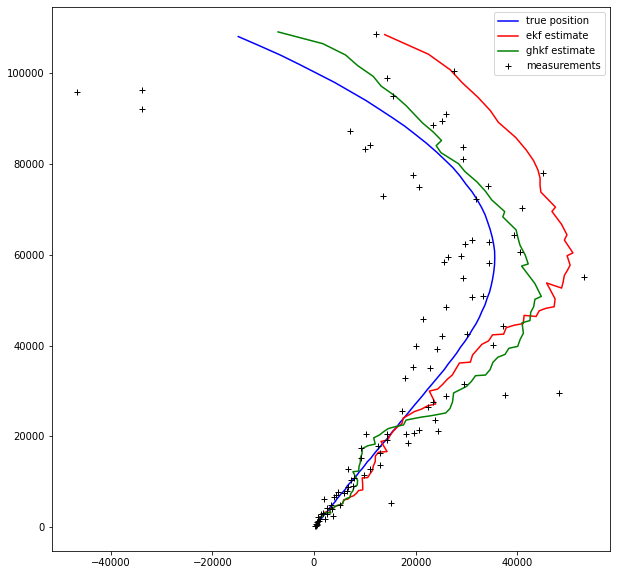

In [65]:
plt.figure(figsize=(10, 10))
plt.plot(pos_x, pos_y, 'b-')
plt.plot(ekf_x, ekf_y, 'r-')
plt.plot(ghkf_x, ghkf_y, 'g-')
plt.plot(z_xs, z_ys, 'k+')
plt.legend(['true position', 'ekf estimate', 'ghkf estimate', 'measurements'])
plt.show()

In [66]:
ekf_x_error = np.array(pos_x_filt) - np.array(ekf_x)
ekf_y_error = np.array(pos_y_filt) - np.array(ekf_y)
ekf_vx_error = np.array(vx_filt) - np.array(ekf_vx)
ekf_vy_error = np.array(vy_filt) - np.array(ekf_vy)
ekf_ax_error = np.array(ax_filt) - np.array(ekf_ax)
ekf_ay_error = np.array(ay_filt) - np.array(ekf_ay)
ghkf_x_error = np.array(pos_x_filt) - np.array(ghkf_x)
ghkf_y_error = np.array(pos_y_filt) - np.array(ghkf_y)
ghkf_vx_error = np.array(vx_filt) - np.array(ghkf_vx)
ghkf_vy_error = np.array(vy_filt) - np.array(ghkf_vy)
ghkf_ax_error = np.array(ax_filt) - np.array(ghkf_ax)
ghkf_ay_error = np.array(ay_filt) - np.array(ghkf_ay)

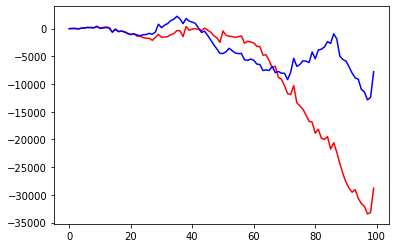

In [67]:
plt.plot(ekf_x_error, 'r-')
plt.plot(ghkf_x_error, 'b-')
plt.show()

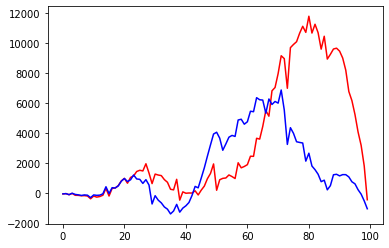

In [68]:
plt.plot(ekf_y_error, 'r-')
plt.plot(ghkf_y_error, 'b-')
plt.show()

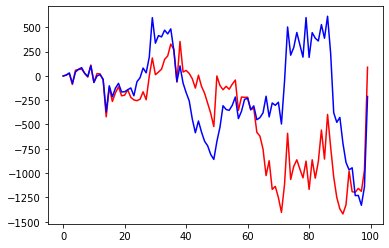

In [69]:
plt.plot(ekf_vx_error, 'r-')
plt.plot(ghkf_vx_error, 'b-')
plt.show()

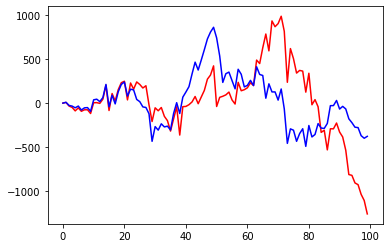

In [70]:
plt.plot(ekf_vy_error, 'r-')
plt.plot(ghkf_vy_error, 'b-')
plt.show()

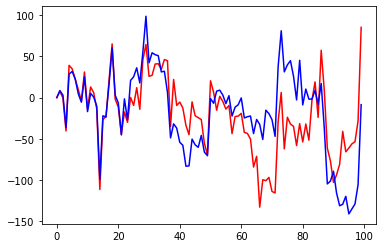

In [71]:
plt.plot(ekf_ax_error, 'r-')
plt.plot(ghkf_ax_error, 'b-')
plt.show()

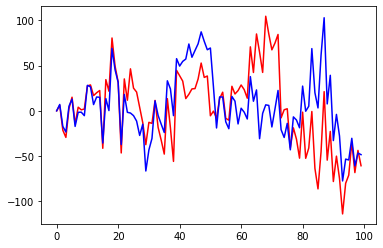

In [72]:
plt.plot(ekf_ay_error, 'r-')
plt.plot(ghkf_ay_error, 'b-')
plt.show()

#### Sarka pendulum

In [85]:
dt = 0.001
qc = 1
Q = np.array([[qc*dt**3/3, qc*dt**2/2], [qc*dt**2/2, qc*dt]])
R = 0.32 * np.eye(1)
R_05 = scipy.linalg.sqrtm(R) 
m = np.array([1.5, 0]).reshape(2, 1)
P = np.eye(2)
nsteps = 5000
p = 4;
sqdt = np.sqrt(dt)
def f(x, u, dt=0.001):
    g = 9.81
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + dt * x2
    x2_next = x2 - g * np.sin(x1) * dt
    return np.array([x1_next, x2_next]).reshape(2, 1)
def h(x):
    x1 = x[0, 0]
    return np.array([np.sin(x1)]).reshape(1, 1)
def F(x, u, dt=0.001):
    g = 9.81
    x1 = x[0, 0]
    return np.array([[1, dt], [-g*np.cos(x1)*dt, 1]])
def H(x):
    x1 = x[0, 0]
    return np.array([np.cos(x1), 0]).reshape(1, 2)

In [88]:
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p)

In [95]:
x = m
xs = []
xs_noisy = []
xs_ekf = []
zs = []
xs_ekf = []
xs_ghkf = []
ts = []
for k in range(nsteps):
    u = 0
    ekf.predict(u)
    ghkf.predict(u)
    x = f(x, u=0)
    xs.append(x)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    xs_noisy.append(x_noisy)
    # measurement
    z = h(x) + multivariate_normal.rvs([0], R)
    ekf.update(z)
    ghkf.update(z)
    xs_ekf.append(ekf.m)
    xs_ghkf.append(ghkf.m)
    zs.append(z)
    ts.append(k*dt)

In [96]:
angle_ekf = list(map(lambda x: x[0, 0], xs_ekf))
angle_ghkf = list(map(lambda x: x[0, 0], xs_ghkf))
angle_true = list(map(lambda x: x[0, 0], xs))
measurements = list(map(lambda x: x[0, 0], zs))

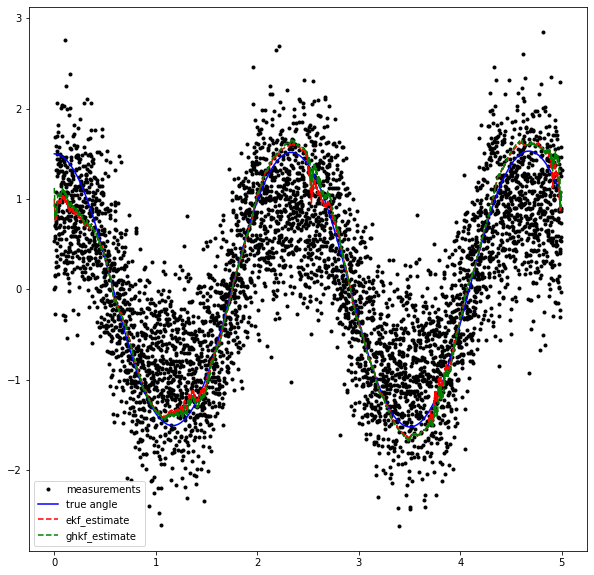

In [101]:
plt.figure(figsize=(10, 10))
plt.plot(ts, measurements, 'k.')
plt.plot(ts, angle_true, 'b-')
plt.plot(ts, angle_ekf, 'r--')
plt.plot(ts, angle_ghkf, 'g--')
plt.legend(['measurements', 'true angle', 'ekf_estimate', 'ghkf_estimate'])
plt.show()

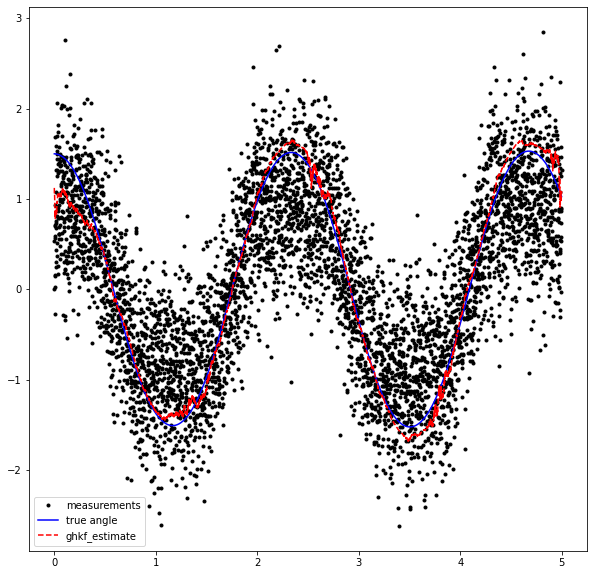

In [98]:
plt.figure(figsize=(10, 10))
plt.plot(ts, measurements, 'k.')
plt.plot(ts, angle_true, 'b-')
plt.plot(ts, angle_ghkf, 'r--')
plt.legend(['measurements', 'true angle', 'ghkf_estimate'])
plt.show()

In [99]:
rmse_ekf = np.sqrt(np.sum((np.array(angle_ekf) - np.array(angle_true))**2 / nsteps))
rmse_ekf

0.14575028710911705

In [100]:
rmse_ghkf = np.sqrt(np.sum((np.array(angle_ghkf) - np.array(angle_true))**2 / nsteps))
rmse_ghkf

0.14158128734250128

#### BOT (Bearing Only Tracking)

In [6]:
x1, x2, x_dash_pk, y_dash_pk = sympy.symbols('x_1, x_2, x_d, y_d')
H = sympy.Matrix([sympy.atan(y_dash_pk / (x1 - x_dash_pk))])
state = sympy.Matrix([x1, x2])
J = H.jacobian(state)
display(state)
display(H)
display(J)

⎡x₁⎤
⎢  ⎥
⎣x₂⎦

⎡    ⎛  y_d   ⎞⎤
⎢atan⎜────────⎟⎥
⎣    ⎝x₁ - x_d⎠⎦

⎡            -y_d                ⎤
⎢─────────────────────────────  0⎥
⎢            ⎛       2       ⎞   ⎥
⎢          2 ⎜    y_d        ⎟   ⎥
⎢(x₁ - x_d) ⋅⎜─────────── + 1⎟   ⎥
⎢            ⎜          2    ⎟   ⎥
⎣            ⎝(x₁ - x_d)     ⎠   ⎦

In [67]:
nsteps = 50
dt = 0.01
m = np.array([45, 30]).reshape(2, 1)
P = np.eye(2)
q = 0.01
# Q = q * np.array([[dt**4/4, dt**3/2],
#                   [dt**3/2, dt**2]])
Q = 0.1 * np.eye(2)
R = 0.1 * np.eye(1)
r_x = 1
r_y = 1
y_dash_pk = 40
x_dash_pk = 50
r_s = 0.052**2 # 3 deg squared
p = 3
kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk }

In [68]:
def f(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    x1_next = x1 + dt * x2
    x2_next = x2
    return np.array([x1_next, x2_next]).reshape(2, 1)
def h(x, **kwargs):
    x1 = x[0, 0]
    y_dash_pk = kwargs['y_dash_pk']
    x_dash_pk = kwargs['x_dash_pk']
    return np.array([np.arctan(y_dash_pk / (x1 - x_dash_pk))]).reshape(1, 1)
def F(x, u, dt, **kwargs):
    x1 = x[0, 0]
    x2 = x[1, 0]
    return np.array([[1, dt],
                     [0, 1]])
def H(x, **kwargs):
    x1 = x[0, 0]
    y_dash_pk = kwargs['y_dash_pk']
    x_dash_pk = kwargs['x_dash_pk']
    return np.array([-y_dash_pk / ((x1 - x_dash_pk)**2 * (y_dash_pk**2 / (x1 - x_dash_pk)**2 + 1)), 0]).reshape(1, 2)

EKF one run:

In [73]:
np.random.seed(2022)
ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt, kwargs=kwargs)
ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt, kwargs=kwargs)
x = m
x_noisy = x
xs = []
xs_estimated_ekf = []
xs_estimated_ghkf = []
ts = []
xs_dash_pk = []
for k in range(nsteps):
    x_dash_pk = 160 * k * dt
    kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk }
    xs_dash_pk.append(x_dash_pk)
    ekf.kwargs = kwargs
    ghkf.kwargs = kwargs
    x1 = x[0, 0]
#     R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
#     ekf.R = R
    u = 0
#     x = f(x, u, dt)
    x, P_true = trueMeanAndCov(x_noisy, ghkf.P, f, u=u, f_return_dim=2, x_dim=2, dt=dt, f_kwargs=kwargs)
    x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
    xs.append(x[0, 0])
    ekf.predict(u)
    ghkf.predict(u)
    z = h(x_noisy, **kwargs)
    z, Pz = trueMeanAndCov(x_noisy, P_true, f=h, u=0, f_return_dim=1, x_dim=2, dt=dt, for_measurement=True, f_kwargs=kwargs)
    z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
#     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
#     zs_x_axis.append(z_x_axis)
    ekf.update(z_noisy)
    ghkf.update(z_noisy)
    xs_estimated_ekf.append(ekf.m[0, 0])
    xs_estimated_ghkf.append(ghkf.m[0, 0])
    ts.append(k*dt)

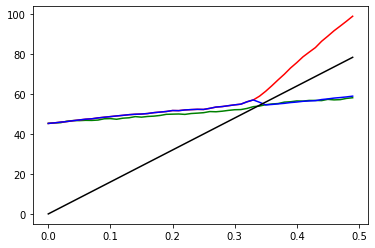

In [74]:
plt.plot(ts, xs, 'g-')
plt.plot(ts, xs_estimated_ekf, 'r-')
plt.plot(ts, xs_estimated_ghkf, 'b-')
plt.plot(ts, xs_dash_pk, 'k-')
plt.show()

EKF:

In [23]:
nsimsteps = 10_000
np.random.seed(2022)
track_loss_cnt = 0
biggest_difference = 0
rmses = []
times = []
for i in range(nsimsteps):
    ekf = EKF.ExtendedKalmanFilter(m, P, Q, R, processModel=f, measurementModel=h, F=F, H=H, dt=dt,
                              processModelkwargs=kwargs, measurementModelkwargs=kwargs, 
                               Fkwargs=kwargs, Hkwargs=kwargs)
    x = m
    xs = []
    xs_estimated = []
#     zs = []
    # zs_x_axis = []
#     xs_dash_pk = []
    t_start = perf_counter()
    for k in range(nsteps):
        x_dash_pk = 4 * k * dt
#         xs_dash_pk.append(x_dash_pk)
        kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk }
        ekf.measurementModelkwargs = kwargs
        ekf.Hkwargs = kwargs
        x1 = x[0, 0]
        R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
        ekf.R = R
        u = 0
        x = f(x, u, dt)
        x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
        xs.append(x[0, 0])
        ekf.predict(u)
        z = h(x_noisy, **kwargs)
        z, Pz = trueMeanAndCov(x_noisy, np.eye(2), f=h, u=0, f_return_dim=1, x_dim=2, dt=dt, for_measurement=True, f_kwargs=kwargs)
        z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
    #     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
    #     zs_x_axis.append(z_x_axis)
        ekf.update(z_noisy)
        xs_estimated.append(ekf.m[0, 0])
    t_stop = perf_counter()
    times.append(t_stop - t_start)
    rmse = np.sqrt(np.sum((np.array(xs) - np.array(xs_estimated))**2 / nsteps))
    rmses.append(rmse)
    difference = np.abs(xs_estimated[-1] - xs[-1])
    if difference > biggest_difference:
        biggest_difference = difference
    is_track_loss = difference >= 5
    if is_track_loss:
        track_loss_cnt += 1
    if i % 1000 == 0:
        print(f'Simulation {i} ended')

Simulation 0 ended
Simulation 1000 ended
Simulation 2000 ended
Simulation 3000 ended
Simulation 4000 ended
Simulation 5000 ended
Simulation 6000 ended
Simulation 7000 ended
Simulation 8000 ended
Simulation 9000 ended


In [24]:
biggest_difference

6.305090740171053

In [25]:
np.mean(rmses)

2.24752075473957

In [26]:
np.mean(times)

0.04523147694000263

In [27]:
track_loss_cnt / nsimsteps

0.0009

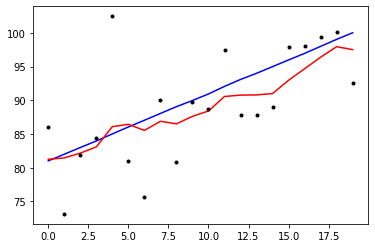

In [23]:
plt.plot(xs, 'b-')
plt.plot(xs_estimated, 'r-')
plt.plot(zs_x_axis, 'k.')
plt.show()

GHKF - 2:

In [28]:
nsimsteps = 10_000
np.random.seed(2022)
track_loss_cnt = 0
biggest_difference = 0
rmses = []
times = []
for i in range(nsimsteps):
    ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=p, dt=dt,
                            processModelkwargs=kwargs, measurementModelkwargs=kwargs)
    x = m
    xs = []
    xs_estimated = []
#     zs = []
    # zs_x_axis = []
#     xs_dash_pk = []
    t_start = perf_counter()
    for k in range(nsteps):
        x_dash_pk = 4 * k * dt
#         xs_dash_pk.append(x_dash_pk)
        kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk }
        ghkf.measurementModelkwargs = kwargs
        x1 = x[0, 0]
        R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
        ghkf.R = R
        u = 0
        x = f(x, u, dt)
        x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
        xs.append(x[0, 0])
        ghkf.predict(u)
        z = h(x_noisy, **kwargs)
        z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
    #     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
    #     zs_x_axis.append(z_x_axis)
        ghkf.update(z_noisy)
        xs_estimated.append(ghkf.m[0, 0])
    t_stop = perf_counter()
    times.append(t_stop - t_start)
    rmse = np.sqrt(np.sum((np.array(xs) - np.array(xs_estimated))**2 / nsteps))
    rmses.append(rmse)
    difference = np.abs(xs_estimated[-1] - xs[-1])
    if difference > biggest_difference:
        biggest_difference = difference
    is_track_loss = difference >= 5
    if is_track_loss:
        track_loss_cnt += 1
    if i % 1000 == 0:
        print(f'Simulation {i} ended')

Simulation 0 ended
Simulation 1000 ended
Simulation 2000 ended
Simulation 3000 ended
Simulation 4000 ended
Simulation 5000 ended
Simulation 6000 ended
Simulation 7000 ended
Simulation 8000 ended
Simulation 9000 ended


In [29]:
biggest_difference

6.013423167301767

In [30]:
np.mean(rmses)

2.252880118045858

In [31]:
np.mean(times)

0.013322915979998243

In [32]:
track_loss_cnt / nsimsteps

0.0008

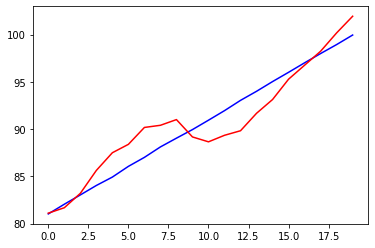

In [216]:
plt.plot(xs, 'b-')
plt.plot(xs_estimated, 'r-')
plt.show()

GHKF - 3:

In [33]:
nsimsteps = 10_000
np.random.seed(2022)
track_loss_cnt = 0
biggest_difference = 0
rmses = []
times = []
for i in range(nsimsteps):
    ghkf = GHKF.GH_Kalman_filter(m, P, Q, R, processModel=f, measurementModel=h, degree=3, dt=dt,
                            processModelkwargs=kwargs, measurementModelkwargs=kwargs)
    x = m
    xs = []
    xs_estimated = []
#     zs = []
    # zs_x_axis = []
#     xs_dash_pk = []
    t_start = perf_counter()
    for k in range(nsteps):
        x_dash_pk = 4 * k * dt
#         xs_dash_pk.append(x_dash_pk)
        kwargs = { 'y_dash_pk': y_dash_pk, 'x_dash_pk': x_dash_pk }
        ghkf.measurementModelkwargs = kwargs
        x1 = x[0, 0]
        R = np.array([(y_dash_pk**2 * r_x + (x1 - x_dash_pk)**2 * r_y) / ((x1 - x_dash_pk)**2 + y_dash_pk**2)**2 + r_s]).reshape(1, 1)
        ghkf.R = R
        u = 0
        x = f(x, u, dt)
        x_noisy = x + multivariate_normal.rvs([0, 0], Q).reshape(2, 1)
        xs.append(x[0, 0])
        ghkf.predict(u)
        z = h(x_noisy, **kwargs)
        z_noisy = z + multivariate_normal.rvs([0], R).reshape(1, 1)
#         zs.append(z_noisy)
    #     z_x_axis = y_dash_pk / np.tan(z_noisy[0, 0]) + x_dash_pk
    #     zs_x_axis.append(z_x_axis)
        ghkf.update(z_noisy)
        xs_estimated.append(ghkf.m[0, 0])
    t_stop = perf_counter()
    times.append(t_stop - t_start)
    rmse = np.sqrt(np.sum((np.array(xs) - np.array(xs_estimated))**2 / nsteps))
    rmses.append(rmse)
    difference = np.abs(xs_estimated[-1] - xs[-1])
    if difference > biggest_difference:
        biggest_difference = difference
    is_track_loss = difference >= 5
    if is_track_loss:
        track_loss_cnt += 1
    if i % 1000 == 0:
        print(f'Simulation {i} ended')

Simulation 0 ended
Simulation 1000 ended
Simulation 2000 ended
Simulation 3000 ended
Simulation 4000 ended
Simulation 5000 ended
Simulation 6000 ended
Simulation 7000 ended
Simulation 8000 ended
Simulation 9000 ended


In [34]:
biggest_difference

6.008808880106287

In [35]:
np.mean(rmses)

2.251634298312462

In [36]:
np.mean(times)

0.018876498549999225

In [37]:
track_loss_cnt / nsimsteps

0.0008